# Chapter 10: Modeling Relationships #
&copy; 2022 Kenneth Winston

In the previous chapter we saw that markets in effect have moods &mdash; at times nervous, at times overconfident &mdash; that persist for a while but eventually revert to some long-term middle-of-the-road mood. We don't find it unusual when our high-strung friend has a meltdown because his socks don't match, but the same behavior in someone who is normally unflappable makes us sit up and take notice. It's the sudden change from a calm mood to panic, and the eventual relaxation back to calm, that produces fat-tailed distributions.

Fat tails would not be so concerning if they were idiosyncratic. A 10-standard-deviation event that affected only a small percentage of a portfolio would be attenuated if all the other assets in the portfolio were conducting business as usual. Fortunately that does sometimes happen, strengthening further the case for diversification.

But relationships between securities are themselves not stable, so what may be uncorrelated behavior in one period can become correlated in another period. In this chapter, we'll analyze relationships between securities and their time-varying properties.

## 10.1 Pearson Correlation ##

The standard measure of a relationship between two random variables $X$ and $Y$ is due to [Karl Pearson](https://www.encyclopediaofmath.org/index.php/Pearson,_Karl) and is accordingly called **`Pearson correlation`**:
$$\rho(X,Y)=\frac{\mathbb{E}[(X-\mathbb{E}[X])(Y-\mathbb{E}[Y])]}{\sigma_X\sigma_Y}\label{eq:pearson_correlation}\tag{10.1}$$
The standard deviations follow from the usual definition of variance:
$$\sigma_X^2=\mathbb{E}[(X-\mathbb{E}[X])^2]$$
and similarly for $\sigma_Y$.

Some obvious facts about Pearson correlation follow directly from \eqref{eq:pearson_correlation}:
$$\rho(X,aX)=
\left\{
\begin{array}{ll}
      1 & a>0 \\
      0 & a=0 \\
      -1 & a<0 \\
\end{array} 
\right.\tag{10.2a}$$
$$F_{X,Y}(x,y)=F_X(x)F_Y(y)\implies\rho(X,Y)=0\label{eq:correlation_independence}\tag{10.2b}$$
In words, \eqref{eq:correlation_independence} says that if $X$ and $Y$ are independent then they are uncorrelated.

However it is not necessarily true that if $X$ and $Y$ are uncorrelated, then they are independent. For example let $X$ be a standard normal random variable and let $Y=X^2$. Then $\mathbb{E}[X]=0$ so $\mathbb{E}[(X-\mathbb{E}[X])(Y-\mathbb{E}[Y])]=\mathbb{E}[XY]=\mathbb{E}[X^3]=0$ with the last equality coming about because the skewness of a normal distribution is zero. Thus $X$ and $Y$ are uncorrelated. But it's intuitively clear they aren't independent; formally we could for example look at $F_{X,Y}(1,1)$ and note that it's the same as $F_{X,Y}(\infty,1)$ since $Y\leq1$ means $X\leq1$. But it's not true that $F_X(1)F_Y(1)=F_X(\infty)F_Y(1)$, so they aren't independent.

Pearson correlations are very widely used and even non-statisticians have a general sense of what correlation means. News media frequently report social science studies whose main results are correlations between socially desirable or undesirable outcomes. For example, a correlation between early childhood education programs and later reduction in poverty rates might be reported. While the general public might not be able to write down \eqref{eq:pearson_correlation} if given a spot quiz, most people understand that the reported study implies that more early childhood education helps lower poverty.

But that may not be true. Virtually every statistics class repeats the warning **`correlation is not causation`**. A standard example is the supposed correlation between ice cream sales and the homicide rate. Ice cream does not cause homicides; warmer weather does. That's because more people are outside interacting, sometimes murderously. By coincidence ice cream sales also go up in warmer weather. Clearly banning ice cream sales would not lower the homicide rate. Would increasing early childhood education cause poverty rates to go down? Correlation neither proves nor disproves that link; it's a necessary but not sufficient condition for the link to exist.

Correlation is a unitless quantity ranging from minus one to one. Even without the complications of causation, the existence of a nonzero correlation might not even be significant. The **`Fisher z-test`** allows us to estimate the statistical significance of an observed correlation. The test uses the **`Fisher z-transform`**:
$$z(\rho)=\frac{1}{2}ln\bigl(\frac{1+\rho}{1-\rho}\bigr)=arctanh(\rho)\label{eq:fisher_ztransfrom}\tag{10.3}$$

Figure 10.1 shows that the z-transform is near-linear when the correlation is small in absolute value. The straight line on the graph goes through the points where the z-transform equals $\pm1$.

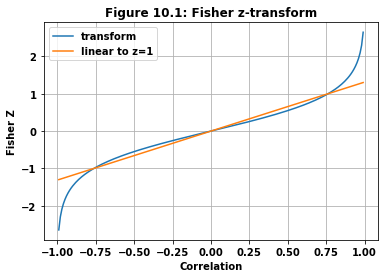

In [1]:
#Show Fisher z-transform
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def fisherz(rho):
    #Fisher z-transform
    return(.5*np.log((1+rho)/(1-rho)))

x=np.arange(-.99,.9999,.01)
plt.plot(x,fisherz(x),label="transform")

fzeq1=(np.exp(2)-1)/(np.exp(2)+1)  #argument where z-transform equals one
plt.plot(x,x/fzeq1,label="linear to z=1")
plt.title("Figure 10.1: Fisher z-transform")
plt.xlabel("Correlation")
plt.ylabel("Fisher Z")
plt.legend()
plt.grid()
plt.show();

Often we are interested in whether or not there is any correlation between two items; in other words, we want to see if we can reject the hypothesis that the correlation is zero. The standard error (standard deviation of the sampling distribution) of the Fisher z-transform is $\frac{1}{\sqrt{n-3}}$, where $n$ is the number of points in the sample from which we compute the sample correlation. This depends on the assumption that the two variables being correlated are bivariate normal.

So for example if there are 15 subjects in a sample, we need $arctanh(r)>\frac{1}{\sqrt{12}}$, or $r>tanh(\frac{1}{\sqrt{12}})=28.1\%$ (or $r<-28.1\%$) for the sample correlation $r$ to have less than a $16\%$ chance ($1-F^{-1}(1)$ where $F$ is the normal cdf) of being zero. Under the assumption of normality, an observed correlation outside the range $\pm56.2\%$ has less than a $2.5\%$ chance of occurring when the true correlation is zero.

The Fisher z-transform significance test is most useful when dealing with small samples &mdash; if n is very large, the standard error is extremely small.

## 10.2 Spearman Correlation ##

Pearson correlation is widely used, but it has some problems. If we have observations $(x_1,y_1),\dots,(x_n,y_n)$, then the finite version of the Pearson correlation in \eqref{eq:pearson_correlation} is
$$\rho(x,y)=\frac{\sum_{i=1}^n(x_i-\overline{x})(y_i-\overline{y})}{(n-1)s_Xs_Y}\label{eq:sample_pearson}\tag{10.4}$$
$\overline{x}$, $\overline{y}$, $s_x$ and $s_y$ are the sample means and standard deviations.

Large unusual observations &mdash; or just plain data errors &mdash; can affect the number disproportionately. For example, suppose we have the following observations of two quantities at six different times:

| Time period | x observation | y observation |
:-:|-:|:-:|
| 1 | 1 | 1 |
| 2 | -0.1 | -0.1 |
| 3 | 1.5 | 1.5 |
| 4 | 1.7 | 1.7 |
| 5 | -1 | -1 |
| 6 | 5 | -2 |

The first five observations are the same and therefore have $100\%$ correlation. However the last large observation makes the overall correlation \eqref{eq:sample_pearson} negative ($-28\%$). Depending on one's intuition about the importance of the dissonant observation, this may seem dissatisfying.

A variation on Pearson correlation that addresses this problem is due to [Charles Spearman](https://doi.org/10.1098%2Frsbm.1947.0006). **`Spearman correlation`** works from ranks rather than from the direct data.

Looking down the "x observation" column of the data table, we see that in the first time period, the $x$ observation is the number 1 which is the fourth biggest $x$: 5, 1.7, and 1.5 are bigger and -0.1 and -1 are smaller. For y observations, the 1 in the first time period is the third biggest. To compute a Spearman correlation, we would replace the first time period's observations with their ranks 4 and 3. Transforming the whole data table into a table of ranks gives

| Time period | x rank | y rank |
:-:|-:|:-:|
| 1 | 4 | 3 |
| 2 | 5 | 4 |
| 3 | 3 | 2 |
| 4 | 2 | 1 |
| 5 | 6 | 5 |
| 6 | 1 | 6 |

The Spearman correlation is just the Pearson correlation of the rank table. The Pearson correlation between the two rank columns (i.e. the Spearman correlation of the original data) is $14.3\%$. The fact that the components of the last pair of observations are at complete opposite ends of the spectrum does bring down the correlation, but it doesn't make it negative since the other five observations are more aligned.

More generally if we have a rank function $r_x$ so that $x(r_x(1))\geq x(r_x(2))\geq\dots\geq x(r_x(n))$, and similarly for $y$, then we look at the pairs $(r_x^{-1}(1),r_y^{-1}(1)),(r_x^{-1}(2),r_y^{-1}(2)),\dots,(r_x^{-1}(n),r_y^{-1}(n))$. Ties are treated by taking the average of the ranks that are tied, i.e. if the $4^{th}$ and $5^{th}$ biggest observations are the same then they are both given rank $4.5$. The average of the numbers from 1 to n is $(n+1)/2$. So for Spearman correlation, \eqref{eq:sample_pearson} becomes
$$\rho_{Spearman}(x,y)=\frac{\sum_{i=1}^n \bigl(r_x^{-1}(i) r_y^{-1}(i)\bigr)-n\frac{(n+1)^2}{4}}{(n-1) s_{r_x^{-1}}s_{r_y^{-1}}}\tag{10.5}$$
Here $s_{r_x^{-1}}$ is the standard deviation of the ranks of the $x$'s, which will be roughly $\sqrt{\frac{n^2-1}{2}}$, with variation depending on how many ranks are tied. Similarly for $s_{r_y^{-1}}$.

The code in the next cell performs the calculations for the Pearson/Spearman example.

In [2]:
import scipy.stats as spst
#Form ranks from Pearson example
x=[1,-.1,1.5,1.7,-1,5]
y=[1,-.1,1.5,1.7,-1,-2]

print("X data:",x)
xr=7-spst.rankdata(x)
print("X ranks:",xr)

print("Y data:",y)
yr=7-spst.rankdata(y)
print("Y ranks:",yr)

pearson,psig=spst.pearsonr(x,y)
#Compute Spearman by doing Pearson on ranks
spearman,ssig=spst.pearsonr(xr,yr)
#Direct call to Spearmsn
spear_scipy,sspsig=spst.spearmanr(x,y)

print("Pearson correlation:",pearson)
print("Spearman correlation from Pearson ranks:",spearman)
print("Spearman from scipy:",spear_scipy)

X data: [1, -0.1, 1.5, 1.7, -1, 5]
X ranks: [4. 5. 3. 2. 6. 1.]
Y data: [1, -0.1, 1.5, 1.7, -1, -2]
Y ranks: [3. 4. 2. 1. 5. 6.]
Pearson correlation: -0.2844419046262927
Spearman correlation from Pearson ranks: 0.14285714285714285
Spearman from scipy: 0.14285714285714288


## 10.3 Conditional Correlation ##

Often in financial applications there are time series of prices or returns or log-returns, and we're interested in estimating future correlations between them. The correlations we've seen so far are static. They assume that there is a stationary underlying process being analyzed. But what if that's not true?

**`Conditional correlation`** is defined in a time series context. Assume we are observing stochastic processes $X_u$ and $Y_u$. We want to know what we expect the correlation to be at some later time $t$ based on what we knew at some earlier time $s$. That is, if $s<t$, we compute:
$$\rho_s(X_t,Y_t)=\frac{\mathbb{E}_s[(X_t-\mathbb{E}_s[X_t])(Y_t-\mathbb{E}_s[Y_t])]}{\sigma_s(X_t)\sigma_s(Y_t)}\tag{10.6}$$

Is this necessary? Maybe correlations are constant over time and we just need to compute a single unconditional correlation. It should be pretty clear that things will not be this easy, but let's check the data. 

The next cell imports daily log-returns of three regional stock indices &mdash; North America, Europe, and Japan &mdash; going back to mid-1990. However, daily returns will give us misleading correlations due to **`asynchronous trading`**. The time zones of the three regions are quite different: during overlapping daylight savings regimes, London markets are open from 3AM to 11:30AM New York time. Tokyo markets are open from 8PM to 2AM New York time; Hong Kong from 9:30PM to 4AM New York time, both one day ahead across the International Date Line. Thus a given date's closing price reflects different sets of information across the three markets, lowering correlation artificially.

Over longer time periods this effect is less noticeable &mdash; a matter of hours out of a month or even a week is not as significant. So we'll mitigate the asynchronous trading effect by changing the daily log-returns to weekly (Wednesday-Wednesday) returns. Wednesdays are usually preferred for weekly data as they tend to be least subject to holidays and end-of-week economic data announcements. We use a weekly periodicity rather than a monthly periodicity because it removes most of the asynchronicity while still having a robust number of observations.

In [3]:
import pandas as pd
#Get regional stock market index data from Ken French's website.
#Convert daily to Wednesday-Wednesday weekly.

ff_head='http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/'
ff_foot="_3_Factors_Daily_CSV.zip"
ff_names=["Europe","North_America","Japan"]

for name_index in range(len(ff_names)):
    print("Inputting ",ff_names[name_index])
    ffurl=ff_head+ff_names[name_index]+ff_foot
    #Skip the header rows
    df_region = pd.read_csv(ffurl, skiprows=6)
    #Standardize name of Date column and market return column
    col0=df_region.columns[0]
    df_region.rename(columns={col0:'Date'},inplace=True)
    df_region.rename(columns={"Mkt-RF":ff_names[name_index]},inplace=True)
    #Merge into aggregate
    if name_index == 0:
        df_returns=df_region[df_region.columns[0:2]]
    else:
        df_returns = df_returns.merge(df_region[df_region.columns[0:2]], 
                            left_on='Date', right_on='Date')

#Convert to log-returns
df_logs_day=np.log(1+df_returns[df_returns.columns[1:]]/100)

#Convert dates to datetime format
df_logs_day.insert(0,"Date",df_returns["Date"],True)
df_logs_day["Date"] = pd.to_datetime(df_logs_day["Date"], format='%Y%m%d')
        
#Convert log-returns to weekly (Wednesday-Wednesday)
#to avoid asynchronous trading effects
df_logs_day = df_logs_day.set_index("Date")
df_logs=df_logs_day.resample('W-Wed').sum()
#(Will include some holidays like July 4 and December 25, so a little off)

#Remove the partial year at the end
lastyear=df_logs.index[-1].year
df_logs.drop(df_logs.index[df_logs.index.year==lastyear],axis=0,inplace=True)

periodicity=52   #For use in later code segments

nobs=len(df_logs)
print(nobs," weekly observations starting",df_logs.index[0].strftime("%Y-%m-%d"), \
      "ending",df_logs.index[-1].strftime("%Y-%m-%d"))

Inputting  Europe
Inputting  North_America
Inputting  Japan
1644  weekly observations starting 1990-07-04 ending 2021-12-29


With the data acquired, we can compute the $3\times3$ correlation matrix and the standard deviations of these securities:

In [4]:
#Get and show correlation matrix and
#standard deviations
corr_matrix=df_logs[df_logs.columns].corr()
cov_matrix=df_logs[df_logs.columns].cov()
std_devs=[]
for i in range(len(ff_names)):
    #Annualize weekly data
    std_devs.append(np.sqrt(periodicity*cov_matrix.iloc[i,i]))
    
print("Correlation matrix and standard deviations (10.10):")
print(corr_matrix)
print('Annualized standard deviations:\n',std_devs)
zsig=np.sqrt(1/(nobs-3))
rsig=(np.exp(2*zsig)-1)/(np.exp(2*zsig)+1)
print('Correlation significance:',rsig)

Correlation matrix and standard deviations (10.10):
                 Europe  North_America     Japan
Europe         1.000000       0.759062  0.500087
North_America  0.759062       1.000000  0.400097
Japan          0.500087       0.400097  1.000000
Annualized standard deviations:
 [0.1841786644194622, 0.16588764601126615, 0.20247265313094603]
Correlation significance: 0.02468070178833984


Comparing these correlations with $tanh\bigl(\frac{1}{\sqrt{n-3}}\bigr)$ (see text after 10.3) shows that all are significantly nonzero, as we would expect with so much data.

Using these correlations (and variances), we can compute the global minimum variance portfolio of the three regional indices:

In [5]:
#Compute minimum variance portfolio of three regions (4.17)
cov_matrix_inverse=pd.DataFrame(np.linalg.pinv(cov_matrix.values), \
            cov_matrix.columns,cov_matrix.index)
u=pd.Series([1]*len(cov_matrix_inverse),index=cov_matrix_inverse.index)
minvport=cov_matrix_inverse.dot(u)
minvar=1/minvport.dot(u)  #This is second part of formula (4.17)
minvport*=minvar    #This is first part of formula (4.17)
print('Minimum variance portfolio:')
print(minvport.to_string())

#Annualized standard deviation
annminstd=np.sqrt(minvar*periodicity)
print('Minimum variance portfolio annualized std deviation:',annminstd)
#Find minimum component standard deviation
compminstd=min(std_devs)
comp_index=std_devs.index(compminstd)
print("Lowest component annualized std deviation",compminstd,"(",df_logs.columns[comp_index],")")

Minimum variance portfolio:
Europe           0.085593
North_America    0.595845
Japan            0.318562
Minimum variance portfolio annualized std deviation: 0.15054193150005715
Lowest component annualized std deviation 0.16588764601126615 ( North_America )


Recall from Chapter 4 that the variance of the global minimum variance portfolio is $\frac{1}{u^{\intercal}C^{-1}u}$ where $C$ is the covariance matrix. Expanding the data in (10.10) into a covariance matrix and performing the calculation gives an annualized standard deviation that is lower than that of the lowest individual component standard deviation. Once again, portfolio construction taking advantage of diversification mitigated the risk while still participating in the linear combination of returns of the components.

But that was in the past. What about the future?

We'll first test the stability of an artificially generated series as we did in Chapter 9. The next code segment takes weekly draws from an artificial reality generated by a multivariate normal distribution with zero means and covariance matrix equal to the correlation matrix in (10.10). The three trailing 52-week correlation pairs are shown in Figure 10.2:

Cholesky:
 [[1.         0.         0.        ]
 [0.75906193 0.65101843 0.        ]
 [0.50008736 0.03148857 0.86540228]]


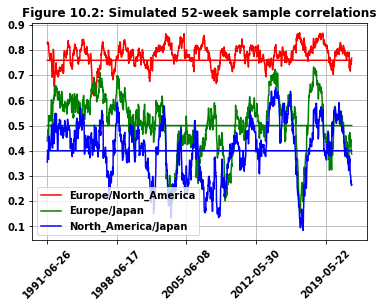

Standard Error =  0.14189319376693255


In [6]:
#Generate graph of either simulated or historical sample correlation
#from df_logs

def make_corr_plot(df_logs, rtrial, samplesize, title_str, simulate):
#Generate a multivariate normal distribution using the data in df_logs
#compute sample correlations of size samplesize and graph them
#simulate: False, use historical data in df_logs
#          True, use simulated data in rtrial
    nobs=len(df_logs)
    corr_matrix=df_logs[df_logs.columns].corr()

    #Get sample correlations
    if simulate:
        samplecorrs=[np.corrcoef(rtrial[i-samplesize:i].transpose()) \
                    for i in range(samplesize,nobs+1)]
    else:
        samplecorrs=[df_logs.iloc[i-samplesize:i][df_logs.columns].corr().values \
                    for i in range(samplesize,nobs+1)]
    sccol=['r','g','b']
    stride=int((nobs-periodicity+1)/(4*periodicity))*periodicity
    
    dates=df_logs.index[samplesize-1:]
    plot_corrs(dates,samplecorrs,corr_matrix,sccol,stride, \
        title_str+str(samplesize)+'-week sample correlations')
#Done with make_corr_plot
    
def plot_corrs(dates,corrs,corr_matrix,sccol,stride,title_str):
    #dates and corrs have same length
    #dates in datetime format
    #corrs is a list of correlation matrices
    #corr_matrix has the target correlations
    #names of securities are the column names of corr_matrix
    #sccol is colors for lines
    #stride is how many dates to skip between ticks on x-axis
    #title_str is title string

    nobs=len(corrs)
    nsecs=len(corrs[0])

    #plot correlations in corrs, nsec per time period
    ncorrs=nsecs*(nsecs-1)/2
    z=0
    #Go through each pair
    for j in range(nsecs-1):
        for k in range(j+1,nsecs):
            #form time series of sample correlations
            #for this pair of securities
            cs=[corrs[i][j,k] for i in range(nobs)]
            plt.plot(range(nobs),cs, \
                     label=corr_matrix.columns[j]+'/'+ \
                     corr_matrix.columns[k], \
                     color=sccol[z])
            #Show target correlation in same color
            line=[corr_matrix.iloc[j,k]]*(nobs)
            plt.plot(range(nobs),line,color=sccol[z])
            z+=1

    plt.legend()
    tix=[x.strftime("%Y-%m-%d") for x in dates[0:nobs+1:stride]]
    plt.xticks(range(0,nobs+1,stride),tix,rotation=45)
    plt.title(title_str)
    plt.grid()
    plt.show();
#Done with plot_corrs
         
#Generate a simulation    
#Show the Cholesky decomposition of the matrix
chol=np.linalg.cholesky(corr_matrix)
print('Cholesky:\n',chol)

#Generate random draws
nobs=len(df_logs)
nsecs=len(df_logs.columns)
strial=np.random.normal(0,1,size=[nobs,nsecs])
rtrial=np.matmul(chol,strial.T).T

samplesize=periodicity
title_str="Figure 10.2: Simulated "
simulate=True
import matplotlib.pyplot as plt
make_corr_plot(df_logs, rtrial, samplesize, title_str, simulate)
print("Standard Error = ",np.tanh(1/np.sqrt(periodicity-3)))

There's a lot of sampling variation. The standard error of a 52-week sample is $14.2\%$, which is larger than the difference between the two smaller correlation pairs. Figure 10.2 shows at most times that Europe/North Americs is the highest correlation, but the other two correlation pairs are often reversed.

Taking longer samples &mdash; three years (156 weeks) with standard error $tanh\bigl(\frac{1}{\sqrt{156-3}}\bigr)\approx8.1\%$ &mdash; produces a clearer picture.

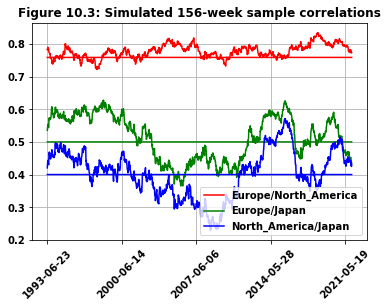

Standard Error =  0.08066953425829816


In [21]:
#Get sample 3-year simulated correlations
samplesize=156
title_str="Figure 10.3: Simulated "
simulate=True
make_corr_plot(df_logs, rtrial, samplesize, title_str, simulate)
print("Standard Error = ",np.tanh(1/np.sqrt(156-3)))

Figure 10.4 shows the historical 156-week correlations:

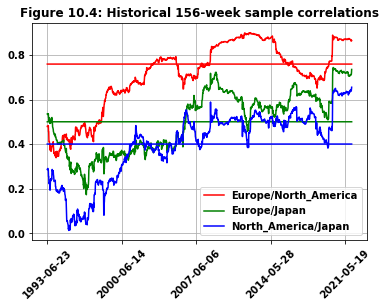

In [22]:
#Get sample 3-year historical correlations
samplesize=156
title_str="Figure 10.4: Historical "
simulate=False
make_corr_plot(df_logs, rtrial, samplesize, title_str, simulate)

It's clear that something more than sampling variation is going on. For example, over the first three years of the data set, the Europe/North America sample correlation was lower than the Europe/Japan sample correlation.

## 10.4 Correlations and the Economy ##

It's important to try to anticipate what correlations will be.[$^1$](#ten_footnotes)
This matters not just to investment portfolios, but also to the economy as a whole. A portfolio or economy that is diversified can better withstand the inevitable shocks that come as the unknown future unfolds.

Countries whose economies are driven by a single commodity are vulnerable to price and demand shocks in that commodity. These countries often seek to diversify their economies by encouraging the development of businesses that have low correlation with the primary commodity. For example, Saudi Arabia has been trying for decades to lower its dependence on oil revenues. The current plan, [Saudi Vision 2030](https://vision2030.gov.sa/en), boasts that
> We are determined to reinforce and diversify the capabilities of our economy, turning our key strengths into enabling tools for a fully diversified future. As such, we will transform [Aramco](https://www.saudiaramco.com/en/#) from an oil producing company into a global industrial conglomerate...

A polite word to use about the Saudis' success with these plans so far is "mixed."

But in broadly diversified economies like those of the United States and the European Union, regions and industries that have low (or at least not perfect) correlation provide opportunities to keep most workers engaged in productive activity. If the construction industry in Nevada is doing badly, then maybe the meat packing plant in Nevada is thriving and hiring workers. Or maybe the construction industry in Iowa is booming.

If the vast majority of a nation's workforce is productively employed, then they have a better chance of collectively producing enough goods and services to make the nation prosper. But in an economy where all business activity is highly correlated, a downturn will lead directly to unemployment: there's nowhere else to work. The idling of significant portions of the workforce lowers the chance that net output is enough to have general prosperity.

Even good times in a highly correlated economy or market can lead to problems. Economies and markets need creative destruction &mdash; there have to be losers such as obsolete industries or technologies that go into decline when new industries or technologies come along. If everything is going up, people lose their motivation to distinguish between the good and the less good and to seek a reasonable price level. This creates bubbles. For example, average house prices in the US went up every quarter for almost 15 years, from third quarter 1992 through first quarter 2007. Figure 10.5 shows that runup in prices, and what happened after that.

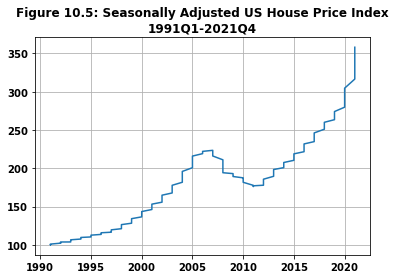

In [23]:
#Get FHFA house price index and graph it
df_fhfa=pd.read_excel( \
        "https://www.fhfa.gov/DataTools/Downloads/Documents/HPI/HPI_PO_summary.xls", \
        skiprows=1)

#Plot seasonally adjusted index
seasonal_index="Seasonally-Adjusted Purchase-Only Index \n(1991Q1=100)"
plt.plot(df_fhfa["Year"],df_fhfa[seasonal_index])
str_title="Figure 10.5: Seasonally Adjusted US House Price Index\n"
str_title+=str(df_fhfa.iloc[0]["Year"])+"Q"+str(df_fhfa.iloc[0]["Quarter"])+"-"
str_title+=str(df_fhfa.iloc[-1]["Year"])+"Q"+str(df_fhfa.iloc[-1]["Quarter"])
plt.title(str_title)
plt.grid()
plt.show();

House prices fell every quarter from second quarter 2007 through second quarter 2011 before finally starting to recover. It took nine years for house prices to get back to their level at the end of first quarter 2007.

A key component of the overheated market leading to this crash was a mistaken belief that house prices in the US were geographically well diversified. It was thought that house prices in Florida had little relationship to house prices in (say) Nevada. This in turn led to banks and investors believing that they would be protected against large downturns if they had a geographically diversified portfolio of mortgages. Investors badly misestimated the correlation matrix between segments of the housing market.

As a result of this misestimation, what in retrospect were too many dollars then flowed into the housing market, misdirecting productive activity into building houses that were not needed. In the second quarter of 2007 the bubble began to burst as house prices declined in a highly correlated way virtually everywhere in the US.

If we could simply predict precisely which activities were going to be useful and therefore profitable, we wouldn't need to worry about predicting correlations. But if we had such predictive powers, there would be neither Knightian Risk nor Knightian Uncertainty in the world. That's not the world we live in.

Thus to form a good investment portfolio &mdash; which in turn helps to direct the economy in the appropriate directions &mdash; we want to avoid gross errors in estimating correlations like those made in the housing market. A well-diversified portfolio is a portfolio that is resilient to the future unfolding in ways we couldn't anticipate.

Unfortunately there is a tendency for correlations to go up in bad markets as investors and business owners become more concerned with the overall economy than with the health of a particular venture. This can lead to "risk-on/risk-off" (sometimes called "RORO") regimes where most risky assets rise together when there is overall good economic news ("risk-on") and most risky assets fall together when there is overall bad economic news ("risk-off").

However even in risk-off regimes, not everything does poorly. Some assets are considered safe havens against economic storms. They may be deemed too unexciting in a risk-on regime, but when things are going badly the clich&eacute; is that "return of capital becomes more important than return on capital." In that case, boring but safe is exactly what investors want.

Safety assets can include US Treasurys, Japanese Government Bonds ("JGB's"), gold, and sometimes cryptocurrencies. The correlations between these safety assets becomes extremely high in risk off regimes, while their correlations with risky assets becomes quite negative. This is another example of the type of regime shifting we have discussed.

But there are no guarantees. For example while US Treasurys have provided good diversification from US stocks since the late 1990s, before that they tended to correlate positively with US stocks, as shown in Figure 10.6.

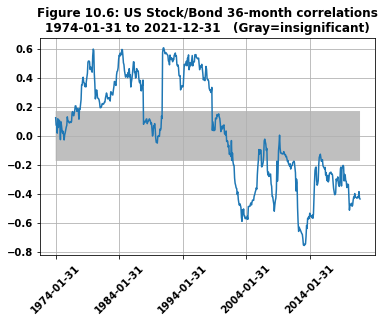

In [24]:
import pandas as pd
import qrpm_funcs as qf
import datetime as dt
from datetime import datetime
import scipy.stats as spst
import numpy as np
import matplotlib.pyplot as plt

firstday="1970-12-31"
lastday=qf.LastYearEnd()
seriesnames=['WILL5000IND','DGS10']
cdates,ratematrix=qf.GetFREDMatrix(seriesnames,
                        startdate=firstday,enddate=lastday)

#Put in dataframe - no na's, only monthends
df_stockbond=pd.DataFrame(ratematrix,index=[datetime.strptime(cd,"%Y-%m-%d") \
                for cd in cdates]).dropna().resample('M').last()

#Convert to log-returns
#Assume Treasury rates given are for 10-year par bond
#paying semiannually
stock_logs=[]
bond_logs=[]
idx_stock=0
idx_tsy=1
T20=20.    #Number of semiannual periods in the 10-year bond
oldrate=df_stockbond.iloc[0][idx_tsy]/200    #Semiannual rate
for i in range(len(df_stockbond)-1):
    stock_logs.append(np.log(df_stockbond.iloc[i+1][idx_stock]/ \
                             df_stockbond.iloc[i][idx_stock]))
    #Use Formula 3.8 to get the duration of the par bond in semiannual periods
    duration=qf.formula3p8(oldrate*100.,oldrate*100.,T20)
    newrate=df_stockbond.iloc[i+1][idx_tsy]/200
    #Return for the month: carry plus principal change
    bond_return=oldrate/6-duration*(newrate-oldrate)
    bond_logs.append(np.log(1+bond_return))
    oldrate=newrate

#bring dates back to strings    
dates=[datetime.strftime(df_stockbond.index[i],"%Y-%m-%d") \
       for i in range(1,len(df_stockbond))]

corrs=[]
stride=36
for i in range(len(stock_logs)-stride):
    rho,p=spst.pearsonr(stock_logs[i:i+stride],bond_logs[i:i+stride])
    corrs.append(rho)

plt.plot(dates[stride:],corrs)
nobs=len(corrs)
stride_ticks=120
plt.xticks(range(0,nobs+1,stride_ticks), \
           dates[stride:-1:stride_ticks], \
           rotation=45)

#Shade insignificant area
fsig=1/np.sqrt(stride-3)
rsig=(np.exp(2*fsig)-1)/(np.exp(2*fsig)+1)

low_sig=[-np.abs(rsig)]*nobs
high_sig=[np.abs(rsig)]*nobs

plt.fill_between(range(nobs), low_sig, high_sig, \
                 facecolor='gray', alpha=0.5, interpolate=True)

str_title="Figure 10.6: US Stock/Bond "+str(stride)+ \
          "-month correlations\n"
str_title+=dates[stride]+" to "+dates[-1]
str_title+="   (Gray=insignificant)"
plt.title(str_title)
plt.grid()
plt.show();

The positive correlations seen in the US before the 2000s were more like stock/bond correlations in emerging markets, where both government bonds and the stock market are strongly influenced by the health of the overall economy and thus have generally positive correlations. It is anyone's guess how long US Treasurys or JGBs will continue to provide safety in market downturns.

## 10.5 Implied Correlations ##

In Chapter 9, we looked both at volatilities obtained form historical log-returns, and at volatilities implied by option prices. The attraction of option-implied volatilities is that since the prices of options move every time the option trades, we get an instant update on the implied volatility. We don't have to smooth over many months or years.

Are there option-implied correlations? Not exactly. There are correlations implied from models of tranched credit; we'll discuss those later in this chapter. However, these correlations are narrowly applicable to the default times of particular assets such as specific pools of loans and are not broadly applicable.

There is a method that uses option-implied volatilities to infer a single marketwide average correlation between a typical pair of stocks. For this method to work, there must exist traded options on a portfolio (such as the [Standard & Poors 500](https://us.spindices.com/indices/equity/sp-500)) and on all the components of the portfolio (such as the 500 stocks in the S&P 500). The general idea is that the implied volatility of the portfolio is a function of the covariance matrix, which contains variances and correlations. The method extracts an average correlation from the difference between the portfolio's variance and its component variances.

Specifically, if $Var_{port}$ is the variance of the portfolio, then
$$Var_{port}=w^{\intercal}Cw=\sum_{i=1}^n{\sum_{j=1}^n{w_iw_j\sigma_i\sigma_j\rho_{ij}}}\label{eq:varport_definition}\tag{10.15}$$

The volatilities ($\sigma_i$'s) of component securities have a wide range. Figure 10.7 below shows the distribution of annualized volatilities of 500 stocks that make up the exchange-traded-fund (ETF) [SPY](https://www.ssga.com/us/en/individual/etfs/funds/spdr-sp-500-etf-trust-spy) which is close to the S&P 500.

506 SPY tickers input,   0.790 seconds
48618 SPY options input,  45.119 seconds
496 SPY tickers matched with options,   6.770 seconds
7612 SPX options input,   7.024 seconds


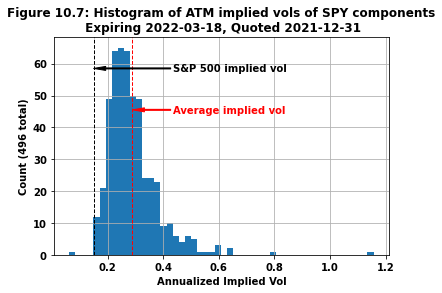

SPX implied: 0.15005000000000002
Number greater: 495
Average implied: 0.2893586525537634
Implied correlation per formula (10.16): 0.29993803783291334


In [25]:
#Read current holdings of SPY Exchange-Traded-Fund (ETF)
#This is very close to the actual S&P 500 index
#There is a time mismatch - this is current while options information is from
#yearend, so implied correlations will be off a little
import pandas as pd
import time
import datetime
import numpy as np

#Function used below to get implied volatilities
def find_implieds(df_ATM,quote_date,day_target):
    #find options in dataframe df_ATM having maturities close to
    #day_target days from quote_date. Return average implieds of those
    #options and a string giving one of the expiration dates used.
    this_implied=0
    num_implied=0
    #Keep increasing the number of days interval
    #around day_target until some options are found
    for interval in range(16,86,10):
        for i_ATM in range(len(df_ATM)):
            if abs( int( \
             (df_ATM.iloc[i_ATM].expiration-quote_date) \
             /np.timedelta64(1, 'D'))-day_target)<interval:
                this_implied+=df_ATM.iloc[i_ATM].implied_volatility_1545
                num_implied+=1
                str_exp = str(df_ATM.iloc[i_ATM].expiration)[:10]
        if num_implied != 0:
            break

    return(this_implied/num_implied,str_exp)
#Done with find_implieds

#
# Step 1 - get SPY tickers
#
start_time = time.perf_counter()
url="https://www.ssga.com/us/en/individual/etfs/library-content/"+\
    "products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx"
df_spy=pd.read_excel(url,skiprows=4,engine="openpyxl")
df_spy.dropna(thresh=3,inplace=True)   #Clean up junk at the end
#Extract tickers and weights
orig_spy_tickers=[df_spy["Ticker"].iloc(0)[i].upper() for i in range(len(df_spy))]
weights=[df_spy["Weight"].iloc(0)[i] for i in range(len(df_spy))]
weights/=sum(weights)    #force weights to add to 1
end_time = time.perf_counter()
print("%d SPY tickers input, %7.3f seconds" % (len(weights),end_time-start_time))

#
# Step 2 - get options on the tickers in SPY
# and compute ATM volatility about 75 days out
#
yearend_string=str(datetime.datetime.now().year-1)
df_spy_options=pd.read_excel(r"SPY_UnderlyingOptionsEODCalcs_"+ \
                             yearend_string+"-12-31.xlsx",engine="openpyxl")
end_time, start_time = time.perf_counter(), end_time
print("%d SPY options input, %7.3f seconds" % (len(df_spy_options), end_time-start_time))

#Match up stock tickers with options
spy_tickers=[]
implieds=[]
vis=[]   #vi's as in (10.16)
for i in range(len(orig_spy_tickers)):
    df_target=df_spy_options[df_spy_options.underlying_symbol == orig_spy_tickers[i]]
    if len(df_target)>0:   #Did we find any options on this ticker?
        spy_tickers.append(orig_spy_tickers[i])
        this_price = df_target.active_underlying_price_1545.unique()[0]
        quote_date = df_target.quote_date.unique()[0]
        #Find closest to the money
        min_to_money = min(abs(df_target.strike.unique()-this_price))
        df_ATM=df_target[abs(df_target.strike-this_price)==min_to_money]
        
        this_avg, str_exp = find_implieds(df_ATM,quote_date,75)
        implieds.append(this_avg)
        vis.append(implieds[-1]*weights[i])

end_time, start_time = time.perf_counter(), end_time
print("%d SPY tickers matched with options, %7.3f seconds" % (len(spy_tickers), \
                                                end_time-start_time))

#
# Step 3: Get SPX implied volatility about 75 days out
#
df_spx_options=pd.read_excel(r"SPX_UnderlyingOptionsEODCalcs_"+ \
                             yearend_string+"-12-31.xlsx", \
                             engine="openpyxl")
end_time, start_time = time.perf_counter(), end_time
print("%d SPX options input, %7.3f seconds" % (len(df_spx_options), \
                                               end_time-start_time))
#Get SPX ATM volatility
this_price = df_spx_options.active_underlying_price_1545.unique()[0]
#Find closest to the money
min_to_money = min(abs(df_spx_options.strike.unique()-this_price))
df_ATM=df_spx_options[abs(df_spx_options.strike-this_price)==min_to_money]

spx_ATM_60to90_implied, str_exp = find_implieds(df_ATM,quote_date,75)

#Make histogram of implieds

n, bins, patches = plt.hist(implieds,bins=50)
plt.axvline(spx_ATM_60to90_implied, color='k', linestyle='dashed', linewidth=1)
plt.annotate('S&P 500 implied vol', xy=(spx_ATM_60to90_implied, .9*max(n)), 
            xytext=(np.average(implieds)*1.5, .9*max(n)), va='center', 
            color='k', arrowprops=dict(color='k',width=1,headwidth=4))
plt.annotate('Average implied vol', xy=(np.average(implieds), .7*max(n)), 
            xytext=(np.average(implieds)*1.5, .7*max(n)), va='center',
            color='r', arrowprops=dict(color='r',width=1,headwidth=4))

plt.axvline(np.average(implieds), color='r', linestyle='dashed', linewidth=1)
plt.xlabel("Annualized Implied Vol")
plt.ylabel("Count ("+str(len(implieds))+" total)")
plt.title("Figure 10.7: Histogram of ATM implied vols of SPY components\n Expiring " \
          +str_exp+", Quoted "+str(quote_date)[:10])
plt.grid()
plt.show()

#Show number greater than SPX implied
n_greater = sum(iv > spx_ATM_60to90_implied for iv in implieds)
print("SPX implied:",spx_ATM_60to90_implied)
print("Number greater:",n_greater)
print("Average implied:",np.average(implieds))

#Do calculation for formula 10.16
var_port=spx_ATM_60to90_implied**2
sum_vi2=sum([vi**2 for vi in vis])
sum_vi_2=sum(vis)**2
implied_corr=(var_port-sum_vi2)/(sum_vi_2-sum_vi2)
print("Implied correlation per formula (10.16):",implied_corr)

Figure 10.7, which is based on cross-sectional rather than time series data, looks roughly lognormal. Note the "Number greater" output by the previous code cell shows that almost all of the individual stocks in the S&P 500 have greater implied volatilities than does the index itself, as expected. This means the portfolio is benefitting from diversification, i.e. comparatively low average correlations.

Note that the weighted average correlation between a pair of different stocks in a portfolio of $n$ stocks looks like $\sum_{i=1}^n\sum_{j\neq i}x_{i,j}\rho_{i,j}$, where $x_{i,j}>0$ is the weight given to the $(i,j)$ correlation. The weights must sum to one: $1=\sum_{i=1}^n\sum_{j\neq i}x_{i,j}$.

A natural weighting scheme is $x_{i,j}=\frac{v_iv_j}{\sum_{k=1}^n\sum_{m\neq i}v_kv_m}$, where $v_i=w_i\sigma_i$. This gives
$$\rho_{average}=\sum_{i=1}^n\sum_{j\neq i}x_{i,j}\rho_{i,j}
=\frac{\sum_{i=1}^n{\sum_{j\neq i}{v_iv_j\rho_{ij}}}}{\sum_{i=1}^n{\sum_{j\neq i}{v_iv_j}}}
=\frac{Var_{port}-\sum_{i=1}^n{v_i^2}}{\overline{\sigma}_{port}^2-\sum_{i=1}^n{v_i^2}}
\label{eq:avg_corr}\tag{10.16}$$
where $Var_{port}$ is from \eqref{eq:varport_definition} and the average portfolio standard deviation is $\overline{\sigma}_{port}=\sum_{i=1}^n{v_i}$

The rightmost equality in \eqref{eq:avg_corr} is computed from market observables:
- $Var_{port}$ is the square of volatility implied by the prices of S&P 500 (portfolio) options; and
- $v_i=w_i\sigma_i$ is the product of the known weight $w_i$ of the $i^{th}$ portfolio component times $\sigma_i$, the volatility implied by prices of options on component $i$.

Inputting these observables into the \eqref{eq:avg_corr} as of the end of last year gave the "Implied correlation" number reported by the previous code segment.

Note that if $\sqrt{Var_{port}}=\overline{\sigma}_{port}=\sum_{i=1}^n{v_i}$, there has been no diversification benefit in the portfolio. That provides an intuitive checkpoint for the rightmost expression in \eqref{eq:avg_corr}: in that case the numerator and denominator are the same and the average correlation is $1$ as expected.

Another intuitive checkpoint can be seen when all the correlations are zero: in that case the variance of the portfolio results only from the diagonal terms of the covariance matrix:
$Var_{port}=\sum_{i=1}^n w_i^2\sigma_i^2=\sum_{i=1}^n v_i^2$. In that case the numerator of the rightmost expression in \eqref{eq:avg_corr} is indeed zero.

[Cboe](www.cboe.com), the largest US options exchange, maintains an index that continually carries out the calculation in \eqref{eq:avg_corr}.[$^2$](#ten_footnotes) Figure 10.8 shows how average US stock correlations have moved since 2007;

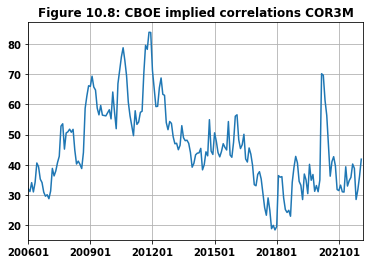

In [26]:
## Graph CBOE COR3N series
## https://www.cboe.com/us/indices/dashboard/cor3m/
## Captured February 26, 2022
import pandas as pd

df_cor3m=pd.read_excel("cboe_cor3m.xlsx",engine="openpyxl")
plt.plot(range(len(df_cor3m)),df_cor3m["COR3M"])
plt.grid()
plt.title('Figure 10.8: CBOE implied correlations COR3M')
nobs=len(df_cor3m)
stride=36
plt.xticks(range(0,nobs,stride),df_cor3m["Date"].iloc[0:nobs:stride])
plt.xlim(0,nobs)
#plt.ylim(25,90)
plt.show()

Before the GFC ("Global Financial Crisis") of 2008-9, average pair correlations in the US were around 40%. During and after GFC, correlations shot up in the RORO (risk-on, risk-off) markets that ensued. It took about ten years for average pair correlations to drop back down to the vicinity of 40%. Correlations shot up again in March 2020 in response to the COVID-19 pandemic and were unstable for more than a year after that.

While Figure 10.8 appears to show that implied correlation is a trailing indicator of market conditions, a [2019 paper](https://dx.doi.org/10.2139/ssrn.3114063) by Buss, Sch&ouml;nleber and Vilkov shows empirical evidence that implied correlation is a robust predictor of long-term market returns.

Buss et. al. note that the individual variances $\sigma_i^2$ seen in \eqref{eq:avg_corr} can be decomposed into a $\beta_i$ component (i.e. a Capital Asset Pricing Model beta to the market portfolio $port$) and an idiosyncratic (non-market) component. They consider the interplay between implied market variance $Var_{port}$, implied idiosyncratic variance, and the implied dispersion of market betas across the members of the portfolio. By looking at the interplay between these components of the implied correlation calculation, Buss et. al. find evidence that implied correlation is a leading procyclical state variable for macroeconomic conditions up to 18 months ahead. This work was done before the COVID-19 pandemic.

## 10.6 Copula Functions ##

To understand fully the relationships between a number of different items &mdash; say scalar random variables $X_1,\dots,X_n$ &mdash; we need to know the full joint distribution
$$F_{\mathbf{X}}(x_1,\dots,x_n)=Pr(X_1\leq x_1,\dots,X_n\leq x_n)\label{eq:joint_distribution}\tag{10.20}$$
Here $\mathbf{X}=(X_1,\dots,X_n)$ is the vector containing all the scalar random variables. This joint distribution function contains much more information than a covariance matrix, which averages over the entire distribution in some way. 

We saw for example that the Europe/North America correlation was high over the many hundreds of weekly observations that we used. So there was a strong tendency for Europe to do well when North America did well. But it's possible that there were nonlinear complications to this relationship. Suppose as a thought experiment that when returns were less than $5\%$ in absolute value, there was no relationship between Europe and North America, and only extreme returns were highly correlated. We might have been planning to incorporate an options strategy that limited large moves, so in this case we would be able to use Europe and North America to diversify each other if we thought the past relationships would continue.

We've been using covariance matrices to describe relationships (which are contained in a correlation matrix) and volatility levels (which can be specified in a vector or in a diagonal matrix). In chapter 9 we saw how constant scalar volatilities were unrealistic descriptions of empirical reality, and how models like GARCH could better describe and anticipate real-world financial distributions.

The process of decomposing a covariance matrix into a correlation matrix and a set of volatilities has an analogy in the context of joint distributions: Define scalar **`marginal distributions`** $F_i$:
$$F_i(x)=Pr(X_1\leq\infty,\dots,X_i\leq x,\dots,X_n\leq\infty)\label{eq:marginal_distribution}\tag{10.21}$$
By setting all the arguments (except the $i^{th}$) of the joint distribution function to infinity, we remove any variation due to those other items. $F_i$ is a univariate cumulative distribution function for each $i$.

The marginal distributions contain information on each variable's volatility, but they contain much more than that. What's left over after the marginal distributions are removed is a copula function, which is analogous to the correlation matrix that is left over after volatilities are removed from the covariance matrix.

To develop this intuitive idea formally, we start by noting that if a scalar real random variable $Y$ has a cdf $F$, we can define another random variable $U$ with range equal to the unit interval $[0,1]$ as $U=F(Y)$. $U$ is called the **`quantiles`** of $Y$. If the original cdf $F$ is invertible, then the cdf of $U$ is
$$F_U(u)=Pr(U\leq u)=Pr(F(Y)\leq u)= \\
Pr(Y\leq F^{-1}(u))=F(F^{-1}(u))=u\label{eq:quantile_cdf}\tag{10.22}$$

\eqref{eq:quantile_cdf} says that $U$ is a uniform random variable. The process of moving from the original random variable X to its quantiles $U$ is essentially the same as finding quantiles for a P-P plot (Section 7.1.1). This process was also used to move from Pearson correlation to Spearman correlation in Section 10.2. While that section used a discrete approach, more generally we can define:
$$Corr_{Spearman}(W,Y)=Corr_{Pearson}(F_W(W),F_Y(Y))=Corr_{Pearson}(U_W,U_Y)$$
where $F_W(w)$ and $F_Y(y)$ are the cdfs for $W$ and $Y$, respectively. $U_W$ and $U_Y$ are their respective quantiles. $Corr_{Pearson}$ is the $\rho$ defined in \eqref{eq:pearson_correlation}.

For each one of the random variables $X_1,X_2,\dots,X_n$ whose joint distribution was given in \eqref{eq:joint_distribution}, we can define its quantiles $U_i=F_i(X_i)$ from its marginal distribution $F_i$. If the marginal distributions are invertible then the random variables $U_1,\dots,U_n$ are all uniformly distributed and thus don't contain much information by themselves. But the relationships between them can be quite complex, as dictated by the original joint distribution function \eqref{eq:joint_distribution}.

Formally, a **`copula function`** is the joint distribution of the $U_i$:
$$C(u_1,\dots,u_n)=Pr(U_1\leq u_1,\dots,U_n\leq u_n)\label{eq:copula_definition}\tag{10.23}$$
The domain of a copula function on $n$ variables is the unit $n$-cube $[0,1]^n$, while its range is the unit interval $[0,1]$. It's a joint distribution function like \eqref{eq:joint_distribution}, but its marginal distributions are all uniform. We can remind ourselves explicitly of the connection between the original joint distribution function \eqref{eq:joint_distribution} and the uniform-ized copula \eqref{eq:copula_definition} by writing it like this
$$C(u_1,\dots,u_n)=Pr\bigl(X_1\leq F_1^{-1}(u_1),\dots,
X_n\leq F_n^{-1}(u_n)\bigr)\label{eq:copula_2}\tag{10.24}$$

The decomposition of \eqref{eq:joint_distribution} into marginals \eqref{eq:marginal_distribution} and a copula function \eqref{eq:copula_definition} is summed up in
>**`Sklar’s Theorem`**[$^3$](#ten_footnotes): Any joint distribution $F_{\mathbf{X}}(x_1,\dots,x_n)$ can be represented as a copula function $C(\cdot)$ of its univariate marginal distributions
$$F_{\mathbf{X}}(x_1,\dots,x_n)=C(F_1(x_1),\dots,F_n(x_n))\label{eq:sklars_theorem}\tag{10.25}$$
When the marginals are continuous, $C(\cdot)$ is uniquely defined. Conversely, any copula function taking any univariate distributions $\{F_i(x_i)\}$ as its arguments defines a valid joint distribution with marginals $\{F_i(x_i)\}$.

Moving from the joint cdf to the joint pdf is straightforward as long as $C(\cdot)$ has $n^{th}$ partial derivatives. Taking the partial derivative of \eqref{eq:sklars_theorem} with respect to every variable gives the pdf, which we denote by lower-case letters to distinguish it from the cdf:
$$\frac{\partial^nF_{\mathbf{X}}(x_1,\dots,x_n)}{\partial x_1\dots\partial x_n}=c(F_1(x_1),\dots,F_n(x_n))f_1(x_1)\cdot f_2(x_2)\cdot\dots\cdot f_n(x_n)\label{eq:copula_density}\tag{10.26}$$
Here $f_i(x_i)=\frac{dF_i(x_i)}{dx_i}$ is the $i^{th}$ marginal density and $c(u_1,\dots,u_n)=\frac{\partial^nC(u_1,\dots,u_n)}{\partial u_1\dots\partial u_n}$. \eqref{eq:copula_density} is analogous to saying that the covariance between two items equals their correlation times their standard deviations.

### 10.6.1 Copula Example: Gaussian Copulas ###

The **`Gaussian (normal) copula`** is widely used in practice. Let $F_S(x)$ be the standard mean-zero variance-one normal cdf. Let $R$ be an $n\times n$ correlation matrix. Let $F_{Norm,R}(x_1,\dots,x_n)$ be the joint cdf of a multivariate normal distribution with mean vector all zeroes and covariance matrix $R$. (Among other things, that means that the marginal variances of this distribution are all one.) The Gaussian (normal) copula is
$$C_{Norm,R}(u_1,\dots,u_n)=F_{Norm,R}(F_S^{-1}(u_1),\dots,F_S^{-1}(u_n))\label{eq:gaussian_copula}\tag{10.27}$$

It may seem disappointing that, after developing the powerful and fully general copula mechanism in the previous section, a model just slips back into using a familiar (and unrealistically low-kurtosis) multivariate normal distribution. But there is a benefit even in this familiar setup. When the full joint distribution is written using Sklar's Theorem:
$$F_{\mathbf{X}}(x_1,\dots,x_n)=C_{Norm,R}(F_1(x_1),\dots,F_n(x_n))$$
any univariate distributions can be used as the marginals $F_i(x_i)$. These marginals could be Student's T distributions, mixtures of normals, or even empirical distributions gathered from observed historical data without imposing a model. A Gaussian copula model can therefore aim for more realistic fat-tailed behavior while preserving simple relationships.

We'll show how Gaussian copulas are applied to financial structures called **`collateralized debt obligations ("CDO"s)`**[$^4$](#ten_footnotes). CDOs are financially engineered products that aim to tailor risk levels to investors' requirements. We will assume away many of the complications that are found in practice since we just want to give the general idea of the application of copulas to these products.

The assets of a CDO consist of a portfolio of bonds. For simplicity, let's suppose that there are 100 bonds each priced at par at the outset of the CDO. Further suppose that the CDO invests $\$1$ million in each bond, so that the CDO's total assets are worth $\$100$ million at its inception. The bonds in a CDO are not default-free.

Ownership of these assets is sliced up into several pieces. The French word for "slice" is "tranche;" the process of dividing up ownership of one of these structures is called "tranching" in Franglais. For simplicity we'll assume that three tranches are used, although in practice the number of tranches is often much higher.

The three parts in our simplified example are:
- A **`senior tranche`** that has a claim on the first $\$60$ million of assets;
- A **`mezzanine tranche`** that has a claim on the middle $\$25$ million of assets; and
- An **`equity tranche`** that has a claim on the bottom $\$15$ million of assets.

At maturity of the CDO, if its total assets are worth more than $\$60$ million, the senior tranche is fully repaid. If the CDO's total assets are worth more than $\$85$ million, both the senior and mezzanine tranches are fully repaid. Any value over $\$85$ million is paid to the equity tranche. The delimeters of each tranche are called its **`attachment point`** (bottom) and its **`detachment point`** (top). In the  example, the mezzanine tranche's attachment point is at $\$15$ million and its detachment point is at $\$40$ million.

Thus the senior tranche is the safest and is appropriate for investors with low risk tolerance. These tranches are often rated AAA &mdash; highest credit quality &mdash; by credit rating agencies. Even when bonds, loans, and mortgages default, there is some recovery of principal. Typical recovery rates are around $40\%$. So virtually every asset in our example structure would have to default before $40\%$ of the value was destroyed and the senior tranche was impaired. That level of defaults has never been experienced, not even in the Global Financial Crisis of 2008. Of course a particular structure could consist of particularly unlucky assets, but it would be fantastically unlikely that the senior tranche would be impaired. Accordingly, a comparatively small percentage the coupon payments being collected on the entire CDO are allocated to the senior tranche.

While a senior tranche is engineered to be especially safe, an equity tranche is engineered for investors with high risk tolerances. Any default in the pool of $100$ CDO assets will hurt the equity tranche, up to $15\%$ of value. After that it doesn't matter because the equity tranche has lost all its value. Dour wits in the financial markets have nicknamed equity tranches "toxic waste" because the bad debts in the CDO pool will collect there. Why would anyone buy toxic waste? Because the compensation is high: a comparatively large percentage of the coupon payments being collected on the entire CDO are allocated to the equity tranche.

To value these tranches, investors focus on a key variable for defaultable bonds: the time between now and when the bond's issuer will run out of money and not be able to repay its debts. That time is not knowable in the present, so time to default is modeled as a random variable. If the average of the time to default variable is centuries from now and the bond matures in $10$ years, then default is not a concern. But if the averagetime to default is earlier than the maturity, the investor will not be repaid.

For a CDO and its tranches, the relationships between the asset times to default (100 of them in our example) are crucial. If times to default are independent, then there may be a few defaults affecting the equity tranche, but it's unlikely that so many defaults will pile up that the senior tranche is affected. But if there is a strong relationship between times to default, it's possible that in a bad market there could be a lot of defaults at the same time and the higher tranches could be affected.

In 2000, [David Li](https://doi.org/10.3905%2Fjfi.2000.319253) introduced the use of Gaussian copulas to model relationships between times to default. For about seven years thereafter, trillions of dollars worth of collateralized obligations were modeled using Gaussian copulas.

This model &mdash; or more precisely the assumptions people used when applying this model &mdash; proved to disastrously overvalue many tranches of collateralized obligations. A typical post-crash comment on the Li copula function model is an article by Felix Salmon with the sensational title [Recipe for Disaster: The Formula That Killed Wall Street](https://www.wired.com/2009/02/wp-quant/).

Li assumed that the default time of the $i^{th}$ asset in a CDO is modeled as an exponential, i.e. the $i^{th}$ asset has a hazard rate $\lambda_i$ so that $F_i(t)=1-exp(-\lambda_i t)$ is the cdf of the asset’s default time. So if $\tau_i$ is the random variable giving the default time of the $i^{th}$ asset, then the probability that the asset defaults before time $t$ is $F_i(t)$.

In this framework there is a common market factor $M$ that affects all assets, so we can define
$$Norm^{-1}(F_i(\tau_i))=X_i=\sqrt{\rho_i}M+\sqrt{1-\rho_i}\epsilon_i\label{eq:li_model}\tag{10.30}$$
Li transformed $\tau_i=F_i^{-1}(Norm(X_i))$ since it will turn out to be more convenient to let $X_i$ give the correlation structure of defaults. $Norm()$ is the standard normal cdf. $M$ and $\epsilon_i$ are standard normals, and correlations between $M$ and $\epsilon_i$ and between $\epsilon_i$ and $\epsilon_j$, $j\neq i$ are zero.

$\epsilon_i$is the idiosyncratic default behavior of the $i^{th}$ asset in the CDO. The correlation matrix $R$ therefore has $Corr(X_i,X_j)=\sqrt{\rho_i\rho_j}$, while the correlation (and covariance) of $X_i$ with itself is one.

The connection between $\tau_i$ and $X_i$ can be rewritten
$$F_i(t)=Pr(\tau_i\leq t)=Pr(F_i(\tau_i)\leq F_i(t)) = Pr( Norm(X_i)\leq F_i(t))\label{eq:li_marginal}\tag{10.31}$$

This shows that $Norm(X_i)$ is the uniformly distributed marginal that appears in a copula function. Further, at a given level $m$ of the market variable $M$, we have
$$Pr(Norm(X_i)\leq F_i(T) | M=m)=\\
Pr(\epsilon_i\leq\frac{Norm^{-1}(F_i(t))-\sqrt{\rho_i M}}{\sqrt{1-\rho_i}}|M=m)\label{li_conditional}\tag{10.32}$$

Putting all the variables together as in Sklar's Theorem, we have
$$Pr(\tau_1\leq t_1,\dots,\tau_n\leq t_n)=
C_{Gauss,R}(F_1(t_1),\dots,F_n(t_n))\label{eq:li_sklar}\tag{10.33}$$

The residuals $\epsilon_i$ are independent by construction. So we can put \eqref{li_conditional} and \eqref{eq:li_sklar} together and integrate over all realizations of the market factor $M$ to get
$$Pr(\tau_1\leq t_1,\dots,\tau_n\leq t_n)=\\
\frac{1}{\sqrt{2\pi}}\int_{-\infty}^{\infty}\bigl[\bigl(\prod_{i=1}^nNorm\bigl(
\frac{Norm^{-1}(F_i(t_i))-\sqrt{\rho_i}m}{\sqrt{1-\rho_i}}\bigr)\bigr)exp(-m^2/2)\bigr]dm\label{eq:li_integral}\tag{10.34}$$

This is a messy integral, but it can be done numerically. The marginal hazard rates $\lambda_i$ can be obtained from market observables like credit default swap spreads. We can then compute the probability that enough assets default to impair a tranche of interest. For example the mezzanine tranche in our three-tranche example would not be impaired until 15% of the asset value was destroyed. After 40% of the asset value was destroyed, the mezzanine tranche would be worthless.

For convenience, market participants make the heroic leap that $\rho_i=\rho$ for all $i$. That is, there is only one average correlation that matters. This is thought of something like an implied volatility in an option pricing context: we can solve for the $\rho$ that makes the observed price of a tranche of a structure equal to the market price.

There isn't the slightest chance that this assumption actually reflects reality; it's simply a computational convenience. The general idea was that the differing correlations would average out in some way so that a single correlation would be good enough. After all, as we saw in a different context in Chapter 4, [Elton & Gruber](https://dx.doi.org/10.2307/2326368) claimed in 1978 that the only information off the diagonal in an equity correlation matrix was the average correlation. So why not default times?

Two things went badly wrong with this assumption. One, which should have been a clue that something was wrong, was that in many cases in order to fit observed market prices, a tranche correlation of $\rho>100\%$ needed to be assumed. This was assumed to be a quirk of the market and a method (called **`base correlation`**) was contrived to avoid seeing correlations over 100%.

A second related problem was that in projecting forward what tranche prices should be based on this model, the assumed physical (as opposed to risk-neutral) correlations were far too low. In fact it turned out that the correlation of subprime mortgages and many other kinds of collateral were far greater than assumed, so that when defaults started, the AAA-rated senior tranches that expected to benefit from a low-correlation subordination buffer below them in fact found that everything went bad at once. Some of the senior tranches were compromised, and even more of them were feared to be compromised whether or not they actually were compromised.

The insurance company AIG got in trouble insuring senior tranches of structured products. Normally insurance companies need to set aside large buffers to make sure that if something bad happens, they can pay off insurance claims. But structured product insurance was exempt from normal insurance rules. AIG was allowed to rely on the assumption that correlations would be low enough between the assets in the structures they insured that they would never have to pay off. When they insured subprime mortgage structures, for example, they assumed that cheap houses in Las Vegas would be uncorrelated with cheap houses in Florida. They were wrong, and ended up needing a [large government bailout](https://www.thebalance.com/aig-bailout-cost-timeline-bonuses-causes-effects-3305693).

## 10.7 Historical Estimation of Correlation Matrices ##

The two most widely used models used to model future correlation matrices are simple historical samples and exponentially weighted moving averages.

Assume we have observations of log-returns $x(i,t)$ of $i=1,\dots,n$ items over $t=1,\dots,T$ time periods, where time period 1 is the most recent. Let $X$ be the $n\times T$ matrix containing these observations, and let the centered observation matrix be $X_C=X(I_T-J_T/T)$ where $I_T$ is the $T\times T$ identity matrix and $J_T$ is the $T\times T$ matrix of all ones. Then the maximum likelihood historical sample covariance matrix is $C=(X_CX_C^{\intercal})/T$. For an unbiased estimate would use $T-1$ instead of $T$ in the denominator, but for most practical implementations $T$ is big enough so it doesn't make a difference.

The **`sample correlation matrix`** is
$$R=S^{-1}CS^{-1}$$
where $S$ is the $n\times n$ diagonal matrix whose diagonal is the square root of the diagonal of $C$.

**`Exponentially weighted moving averages`** ("EWMA"), which we saw in Section (8.1), are based on the premise that older observations are less important than newer ones. They are a special case of GARCH(1,1), which in Chapter 9 we saw was:
$$\sigma_t^2=c+b_1\sigma_{t-1}^2+a_1 y_{t-1}^2\tag{9.41, again}$$
EWMA simply sets $c=0$ and $a_1=1-b_1$.

With GARCH the time index increases as time goes into the future. When taking samples, the time index increases as time goes into the past. We'll use the past-increasing convention here, so period 1 is the most recent past period and period $T$ is the longest-ago period in our sample. So we weight the log-return observations with weights
$$p_{\lambda}(t)=\frac{(1-\lambda)\lambda^{t-1}}{1-\lambda^{\intercal}}\label{eq:ewma_correl}\tag{10.40}$$
This is the same as (7.1) with $\lambda=2^{-h}$. 

The re-centered EWMA observation matrix is $X_{\lambda}=XP_{\lambda}(I_T-J_T/T)$ where $P_{\lambda}$ is the $T\times T$ matrix with $p_{\lambda}(t), t=1,\dots,T$ on its diagonal and zeros elsewhere. The EWMA covariance matrix is $C_{\lambda}=X_{\lambda}X_{\lambda}^{\intercal}$. When $\lambda=1$, $p_{\lambda}(t)=\frac{1}{T}$ and this is the same as the maximum likelihood historical sample covariance matrix.

EWMA (and therefore historical) covariance and correlation matrices are by construction positive semidefinite, and possibly strictly positive definite. This is because for any $n$-vector $z$, we can define $y=X_{\lambda}^{\intercal}z$. Since $y^{\intercal}y$ is a sum of squares, it must be non-negative. But $y^{\intercal}y=z^{\intercal}C_{\lambda}z$, proving that the quadratic form is always non-negative which is the definition of positive definite.

Most commercial systems in use today ([Axioma](https://www.axioma.com/) or [Northfield](https://www.northinfo.com/) for equities, [The YieldBook](https://www.yieldbook.com/m/home/index.shtml) for fixed income, [MSCI](https://www.msci.com/analytics) for multiple asset classes) have exponential weighting as an option, often the default option.

There is widespread skepticism among practitioners over the use of historical and exponentially weighted models, however. These models project either the recent past (exponentially weighted) or a longer view of the past (historical unweighted) forward. As we saw in Figure 8.4, leading up to the global financial crisis of 2008 there was a period of unusually low volatility caused in part by the relatively low correlations shown on the left of Figure 10.8.

These benign conditions began to change in 2007, and then changed massively in the fall of 2008. Many practitioners feel that projecting the past forward works only when you don't really need it to work, i.e. when times are calm. When times are turbulent, projecting the past forward is dangerous.

On the other side of the 2008 GFC, most backward-looking models continued to have a large influence from the high volatilities and correlations for years afterward. That led to very large estimates of variance and very poor expectations of diversification &mdash; except between safety assets and risk assets &mdash; in a period where volatility was on the way down and diversification was improving.

Effects like these are called **`procyclical`**. When conditions were recently good, procyclical risk models say it's OK to take more risk, which is a bad feedback loop leading to a bubble. When conditions were recently bad, procyclical risk models say that just about anything you do except diversifying into safety assets will be very risky, which is a bad feedback loop that drives already-low economic activity even lower.

One way to aim for **`countercyclicality`**, the beneficial opposite of procyclicality, is to use very long-run estimates of relationships and volatilities. But John Maynard Keynes[$^5$](#ten_footnotes) nicely captures the problems of long-run estimates in one of his most famous quotes:
>[The] long run is a misleading guide to current affairs. In the long run we are all dead. Economists set themselves too easy, too useless a task if in tempestuous seasons they can only tell us that when the storm is past the ocean is flat again.

The United States in the 1920s was a manufacturing economy while today it is a service and knowledge-based economy. Mixing in data from the 1920s with more current data doesn't necessarily lead to the discovery of a universal long-run truth: there may not be a universal long-run truth to discover. Further, even if there is some long-run equilibrium, the sojourns away from that equilibrium can be painfully long. A witty summation of this phenomenon, sometimes attributed to Keynes[$^6$](#ten_footnotes), is:
>The markets can stay irrational longer than you can stay solvent.

A technique that is sometimes used to mediate between the long term and the short term is to scale historical estimates of volatilities by option-implied volatilities and to scale historical correlations by option-implied correlations from \eqref{eq:avg_corr}. This assumes that the options market quickly impounds information that seeps more slowly into historical data.

Unfortunately the options market tends to overreact: implied volatilities are almost always higher than subsequent realized volatilities. Implied volatilities spike up briefly on just about any piece of news, and usually quickly subside. Even so, a thoughtful approach to finding the right mix of quick-reaction data and slow-reaction data is necessary to avoid procyclicality without underreaction.

## 10.8 Time Series Estimates of Covariances and Correlations ##

The success of GARCH models in lowering kurtosis of de-GARCHed financial time series leads to an obvious suggestion: why not construct analogous models for covariances? We might try a variant of (8.41):
$$\sigma_{i,j,t}^2=c_{i,j}+b_{i,j}\sigma_{i,j.t-1}^2+a_{i,j}y_{i,t-1}y_{j,t-1}\label{eq:garch_correlation}\tag{10.41}$$

As in Chapter 9, the y's are mean 0 shocks. But the problem is apparent: if there are $n$ securities in the universe, then there will be about $n^2/2$ correlation pairs to estimate. \eqref{eq:garch_correlation} needs to estimate three parameters ($c_{i,j}$, $b_{i,j}$, and $a_{i,j}$ per covariance pair. Unless the number of time periods is substantially larger than the square of the number of securities, each covariance will have little statistical validity.

For this reason, individual correlation GARCH models like \eqref{eq:garch_correlation} just don't work very well empirically. To have any hope of producing statistically robust estimates, we will need to make some decisions about how to restrict the number of parameters.

### 10.8.1 Constant and Dynamic Conditional Correlation ###

Tim Bollerslev, who was a PhD student of Robert Engle and who extended Engle's ARCH model to the more widely used GARCH model, described **`constant conditional correlation`** ("CCC") in a [1990 paper](https://www.jstor.org/stable/2109358). The model simply postulates a constant correlation matrix with time-varying volatilities:
$$\sigma_{i,j,t}^2=\rho_{i,j}\sigma_{i,i,t}\sigma_{j,j,t}\label{eq:ccc_model}\tag{10.42}$$

But we've seen above that constant correlations seem unlikely to fit empirical data. [Engle's 2002](https://doi.org/10.1198/073500102288618487) **`dynamic conditional correlations`** ("DCC") seem to be more realistic. In this model, shocks are first standardized:
$$\epsilon_{i,t}=\frac{y_{i,t}}{\mathbb{E}_{t-1}[y_{i,t}^2]}\label{eq:dcc_standard}\tag{10.43a}$$
Then time-varying correlations between standardized shocks are computed:
$$\rho_{i,j,t}=\frac{\mathbb{E}_{t-1}[\epsilon_{i,t}\epsilon_{j,t}]}{\sqrt{\mathbb{E}_{t-1}[\epsilon_{i,t}^2]\mathbb{E}_{t-1}[\epsilon_{j,t}^2]}}
=\mathbb{E}_{t-1}[\epsilon_{i,t}\epsilon_{j,t}]
\label{eq:dcc_correl}\tag{10.43b}$$
Substituting the dynamic correlation $\rho_{i,j,t}$ for the constant correlation $\rho_{i,j}$ in \eqref{eq:ccc_model} produces DCC covariances.

Both CCC and DCC separate the problem of estimating covariances into a problem of estimating variances, followed by a problem of estimating correlations. As we've noted, this is not a perfect model since in times of stress it's often the case that both volatilities and correlations go up. Thus the two estimation problems are not as independent as this method indicates. Still, we might be able to get better estimates than we have previously.

An obvious way of approaching DCC is to use GARCH for the volatilties, as we noted for CCC. The denominator terms $\mathbb{E}_{t-1}[y_{i,t}^2]$ in \eqref{eq:dcc_standard} could be computed with a GARCH model. We could also use EGARCH or TARCH or any of the other ARCH-like models that we thought were appropriate.

Let's return to the regional stock market index data to see how this works. First we need to estimate GARCH volatilities of each of the region indices separately. Using the log-maximum-likelihood function (8.42), we get the following parameters and evolution of the GARCH processes:

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


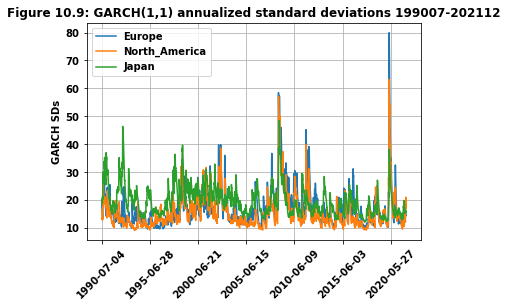

Europe a=0.1909 b=0.7515 c=0.00003922 AnnEquilibStd=0.1882
North_America a=0.1775 b=0.7617 c=0.00003450 AnnEquilibStd=0.1719
Japan a=0.1169 b=0.8332 c=0.00004122 AnnEquilibStd=0.2072


In [27]:
import scipy.stats as spst
from scipy.optimize import minimize_scalar

#CHEAT! - get overall mean and standard deviation vectors
#In practice, would need to do everything out of sample - 
#start with a learning sample, e.g.
overallmean=np.mean(df_logs)
overallstd=np.std(df_logs)
tickerlist=df_logs.columns

#Get GARCH params for each ticker
initparams=[.12,.85,.6]
gparams=[qf.Garch11Fit(initparams,df_logs[ticker]) for ticker in tickerlist]

minimal=10**(-20)
stgs=[] #Save the running garch sigmas
for it,ticker in enumerate(tickerlist):
    a,b,c=gparams[it]
    
    #Create time series of sigmas
    t=len(df_logs[ticker])
    stdgarch=np.zeros(t)
    stdgarch[0]=overallstd[ticker]
    #Compute GARCH(1,1) stddev's from data given parameters
    for i in range(1,t):
        #Note offset - i-1 observation of data
        #is used for i estimate of std deviation
        previous=stdgarch[i-1]**2
        var=c+b*previous+\
            a*(df_logs[ticker][i-1]-overallmean[ticker])**2
        stdgarch[i]=np.sqrt(var)

    #Save for later de-GARCHing
    stgs.append(stdgarch)
    stdgarch=100*np.sqrt(periodicity)*stgs[it]  #Annualize
    plt.plot(range(len(stdgarch)),stdgarch,label=ticker)
    
plt.grid()
plt.title('Figure 10.9: GARCH(1,1) annualized standard deviations '+ \
          min(df_logs.index.strftime("%Y%m"))+'-'+ \
          str(max(df_logs.index.strftime("%Y%m"))))
plt.ylabel('GARCH SDs')
plt.legend()
stride=5*periodicity
tix=[x.strftime("%Y-%m-%d") for x in df_logs.index[0:len(df_logs)-1:stride]]
plt.xticks(range(0,len(df_logs),stride),tix,rotation=45)
plt.show()

for it,ticker in enumerate(tickerlist):
    print(ticker,'a=%1.4f' % gparams[it][0], \
               'b=%1.4f' % gparams[it][1], \
               'c=%1.8f' % gparams[it][2], \
               'AnnEquilibStd=%1.4f' % \
               np.sqrt(periodicity*gparams[it][2]/ \
                       (1-gparams[it][0]-gparams[it][1])))

The separation of relationships and marginal distributions embodied in Sklar's Theorem, or in the two-part de-GARCHing and correlation estimation, seems to fit the patterns we see here. 

The next step is to use these volatilities to de-GARCH the three time series of Europe, North America, and Japan shocks. We divide $y_t$ by $\sigma_t$ because $\sigma_t$ is a function of the previous $y$'s and doesn't "know" $y_t$. We did actually cheat a little bit when forming Figure 10.9: we used the long-term average volatility over the entire sample to start the process. But we couldn't have known the end-of-sample information back in 1990. This doesn't make a huge difference, though: we could have just held out a year at the beginning of the sample to form an initial volatility that would have been of the same order of magnitude as the overall volatility. Similarly we used an overall mean to center the series but could have used a trailing mean, or even ignored the mean, without too much impact.

We noted in Chapter 9 that de-GARCHing often improves the properties of the time series. Let's check:

In [15]:
#Display before and after deGARCHing statistics

#Demeaned, DeGARCHed series go in dfeps
dfeps=df_logs.sort_values(by="Date").copy()
for it,ticker in enumerate(tickerlist):
    dfeps[ticker]-=overallmean[ticker]
    for i in range(len(dfeps)):
        dfeps[ticker].iloc[i]/=stgs[it][i]
    print(ticker)
    print('    DeGARCHed Mean:',np.mean(dfeps[ticker]))
    
    print('    Raw annualized Std Dev:',np.sqrt(periodicity)*overallstd[ticker])
    print('    DeGARCHed Std Dev:',np.std(dfeps[ticker]))
    
    print('    Raw excess kurtosis:',spst.kurtosis(df_logs[ticker]))
    print('    DeGARCHed Excess Kurtosis:',spst.kurtosis(dfeps[ticker]))

Europe
    DeGARCHed Mean: -0.005893477107448027
    Raw annualized Std Dev: 0.18412264048982568
    DeGARCHed Std Dev: 1.0009208480512117
    Raw excess kurtosis: 6.220045614600393
    DeGARCHed Excess Kurtosis: 1.609790869370185
North_America
    DeGARCHed Mean: -0.016313959090731925
    Raw annualized Std Dev: 0.16583718588963886
    DeGARCHed Std Dev: 1.0001415608212971
    Raw excess kurtosis: 6.05442111241195
    DeGARCHed Excess Kurtosis: 2.5632192573140795
Japan
    DeGARCHed Mean: -0.011105611175006004
    Raw annualized Std Dev: 0.2024110644897854
    DeGARCHed Std Dev: 1.0011888821834636
    Raw excess kurtosis: 2.214332485567999
    DeGARCHed Excess Kurtosis: 1.8649442768900748


The de-GARCHed means are no longer zero because the scaling changes them, but they aren't very large. The de-GARCHed time series is scaled so that the weekly standard deviation is close to one, so the means are small fractions of a weekly standard deviation.

The scaling worked well: all three regions have standard deviations close to one. Since $\sigma_t$ didn't "know" what $y_t$ was going to be, this is a good test of persistence of standard deviation estimates.

The de-GARCHing process also took a dent out of excess kurtosis, lowering it in all three regions. The world is still not multivariate normal even after de-GARCHing, but it's not as bad as it was before. Intuitively this means that big shocks (the ones that cause positive kurtosis) don't come out of the blue as much as we might think. The March 2011 earthquake and tsunami in Japan was a shock out of the blue. But in fact such shocks do not seem to move the financial markets as much as self-caused shocks, like the bankruptcy of Lehman Brothers in September 2008. And the latter seem to come only after a buildup that the GARCH model can (partially) catch.

Figure 10.10 shows the historical correlations of the de-GARCHed time series. Comparing this to Figure 10.4 (raw historical correlations) shows that de_GARCHing doesn't seem to make the time series of correlations any steadier.

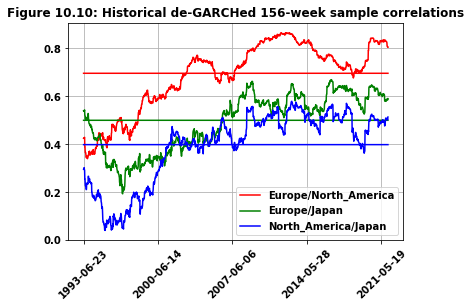

In [16]:
#Get sample 156-month de-GARCHED correlations
samplesize=3*periodicity
title_str="Figure 10.10: Historical de-GARCHed "
simulate=False
make_corr_plot(dfeps, rtrial, samplesize, title_str, simulate)

### 10.8.2 Implementation of Dynamic Conditional Correlations ###

\eqref{dcc_standard} and \eqref{dcc_correl} give a theoretical model for dynamic conditional correlations. But there's more work to be done to get to a practical implementation, since these equations call for taking expected values. We'd have to know the relevant distributions in order to be able to take expected values.

Practical implementations of dynamic conditional correlations focus on the time evolution of the **`quasi-correlation matrix`**. The quasi-correlation matrix is the covariance matrix of the de-GARCHed series; it's called quasi-correlation because the variances are (we hope) close to, but not exactly equal to, one.

There are three common specifications of how the quasi-correlations evolve: integrated, mean-reverting, and asymmetric.

Integration refers to the time series property that differences are stationary. The **`integrated model`** is similar to the exponentially weighted estimation method, except that it's applied to standardized shocks. The matrix specification is:
$$Q_t=\lambda \epsilon_{t-1}\epsilon_{t-1}^{\intercal}+(1-\lambda)Q_{t-1}
\label{eq:integrated_model}\tag{10.44}$$
Here the Q's are $n\times n$ matrices and $\epsilon$'s are $n$-vectors.

Integrated models have no tendency to return to any sort of long-term average, so if we believe that the economic environment is constantly changing so that correlations are never stable, this is the appropriate model. Note that as long as the process is originally seeded with a positive semidefinite $Q_0$, the $Q_t$ will stay positive semidefinite as long as $\lambda$ is in the unit interval.

If we believe that there is a long-term mean correlation matrix that is similar to the equilibrium value in an Ornstein-Uhlenbeck process, then the **`mean-reverting model`** is appropriate:
$$Q_t=\Omega+a\epsilon_{t-1}\epsilon_{t-1}^{\intercal}+\beta Q_{t-1}
\label{eq:mean_reverting}\tag{10.45}$$

If $R$ is the long-term mean correlation matrix we want to target in \eqref{eq:mean_reverting}, then we set $\Omega=(1-\alpha-\beta)R$. We must also have positive $\alpha$, $\beta$, and $1-\alpha-\beta$. The initial quasi-correlation matrix $Q_0$ must be positive semidefinite.

The $\Omega$ parameter matrix doesn't change with time, but it does introduce approximately $n^2/2$ values to be estimated. Usually we simply assume that the long-term mean correlation matrix $R=\Omega/(1-\alpha-\beta)$ will be the past sample correlation matrix; this is called **`correlation targeting`**.

The **`asymmetric model`** uses the insight behind TARCH that we saw in Chapter 9: downward movements tend to cause higher correlations than upward ones. We modify \eqref{eq:mean_reverting} by adding a term that increases correlations when there are joint down-moves:
$$Q_t=\Omega+a\epsilon_{t-1}\epsilon_{t-1}^{\intercal}+
\gamma\eta_{t-1}\eta_{t-1}^{\intercal}+
\beta Q_{t-1},\quad\eta_{t-1}=min(\epsilon_{t-1},0)
\label{eq:asymmetric_model}\tag{10.46}$$
The minimization in the definition of $\eta_{t-1}$ is component-by-component, so $\eta_{t-1}$ is the same as $\epsilon_{t-1}$ where $\epsilon_{t-1}$ has a negative entry, and zero otherwise. Thus the added term $\gamma\eta_{t-1}\eta_{t-1}^{\intercal}$ will have a zero in cell $(i,j)$ if either $\epsilon_{t-1}(i)$ or $\epsilon_{t-1}(j)$ is positive. Otherwise this new term will have a positive entry (since we assume $\gamma>0$), boosting correlation when both elements of the correlation pair have negative returns.

The anchor matrix $\Omega$ can be targeted to equal $(1-\alpha-\beta)R-\gamma N$, where $N$ is the sample correlation matrix of the (negative-only) $\eta$’s. If $(1-\alpha-\beta-\gamma)$ is positive, $\alpha$, $\beta$, and $\gamma$ are also all positive, and the initial $Q_0$ is positive semidefinite, then the $Q_t$ will remain positive semidefinite. The positivity of $(1-\alpha-\beta-\gamma)$ is an overly strong condition that can be relaxed a bit, but it doesn't hurt much to insist on it.

In all three models &mdash; integrated, mean-reverting, and asymmetric &mdash; there is no guarantee that the diagonals of the quasi-correlation matrices $Q_t$ will be all ones. As we saw above when comparing before and after statistics of our three regional indices, de-GARCHing does a good but not perfect job of predicting next-period variance. That's why the $Q_t$ are quasi-correlation matrices but not correlation matrices.

This is easily cured by scaling. We treat the quasi-correlation matrix like it is a covariance matrix to get the actual estimates of correlation:
$$\rho_{i,j,t}=\frac{q_{i,j,t}}{\sqrt{q_{i,i,t}q_{j,j,t}}}\label{eq:quasi_scale}\tag{10.47}$$
In matrix form, that is:
$$R_t=\bigl(diag(Q_t)\bigr)^{-1/2}\cdot Q_t\cdot \bigl(diag(Q_t)\bigr)^{-1/2}\label{eq:quasi_scale_matrix}\tag{10.48}$$

We now have a process for estimating dynamic conditional correlations. It remains only to find the familiar maximum likelihood estimator of the parameters in our models. This is a three-step process:
- First, estimate each GARCH series separately using (8.42)
- Second, if necessary (mean-reverting or asymmetric), compute the average R (sample correlation) and N (asymmetric correlation) matrices from the de-GARCHed series. These can be done with simple historical estimates, or using exponential weighting.
- Third, minimize the (opposite of) the log-likelihood function
$$LML_{corr}=\sum_{t=1}^T\bigl[ln(det(R_t))+\epsilon_t^{\intercal}R_t^{-1}\epsilon_t\bigr]\label{eq:corr_maxlike}\tag{10.49}$$

The likelihood function doesn't look intimidating when written in matrix form, but the variables to be estimated are contained in highly nonlinear ways in the function. For example, if we're using the integrated model, there's only one variable ($\lambda$) to be estimated in the third step. However when we apply \eqref{eq:quasi_scale_matrix} to rescale the quasi-correlation matrix $Q_t$ to the actual correlation matrix $R_t$, we get a complex expression in $\lambda$. The determinant of $R_t$ and the quadratic form in the inverse of $R_t$ shown in \eqref{eq:corr_maxlike} make things even more complicated.

It is still possible to find a minimum of \eqref{eq:corr_maxlike} (and hence a maximum of the log-likelihood function), but there is a chance that an optimizer will get stuck. The statistical properties such as confidence intervals around the statistics are also hard to compute.

We soldiered through these potential problems and computed the $\lambda$ for the integrated model of correlations for our three regional stock market indices in the next code segment.

Optimal lambda: 0.011184559944661282
Optimal objective function: 3305.2122319031564
Half-life (years): 1.1851221760570019


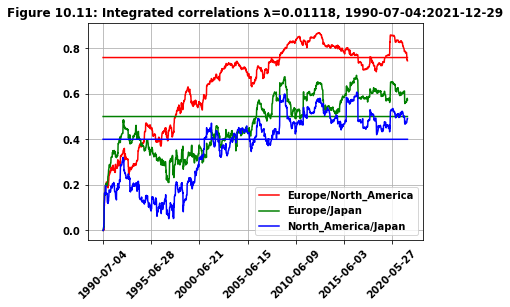

In [17]:
#Compute integrated correlations

InData=np.array(dfeps[tickerlist])

def IntegratedCorrObj(s):
    #Compute time series of quasi-correlation
    #matrices from InData using integrated parameter
    #xlam=exp(s)/(1+exp(s)); note this format removes
    #the need to enforce bounds of xlam being between
    #0 and 1. This is applied to formula 10.44.
    #Standardize Q's and apply formula 10.49.
    #Returns scalar 10.49
    xlam=np.exp(s)
    xlam/=1+xlam
    obj10p49=0.
    previousq=np.identity(len(InData[0]))
    #Form new shock matrix
    for i in range(len(InData)):
        #standardize previous q matrix
        #and compute contribution to objective
        #function
        stdmtrx=np.diag([1/np.sqrt(previousq[s,s]) for s in range(len(previousq))])
        previousr=stdmtrx @ (previousq @ stdmtrx)
        #objective function
        obj10p49+=np.log(np.linalg.det(previousr))
        shockvec=np.array(InData[i])
        vec1=shockvec @ np.linalg.inv(previousr)
        #This makes obj10p49 into a 1,1 matrix
        obj10p49+=vec1 @ shockvec
              
        #Update q matrix
        shockvec=np.mat(shockvec)
        shockmat=np.matmul(shockvec.T,shockvec)
        previousq=xlam*shockmat+(1-xlam)*previousq
    return(obj10p49[0,0])
#Done with IntegratedCorrObj

result=minimize_scalar(IntegratedCorrObj)

xlamopt=np.exp(result.x)
xlamopt/=1+xlamopt
print('Optimal lambda:',xlamopt)
print('Optimal objective function:',result.fun)
if xlamopt>=1 or xlamopt==0:
    halflife=0
else:
    halflife=-np.log(2)/np.log(1-xlamopt)
print('Half-life (years):',halflife/periodicity)

#Compute integrated correlations
nobs=len(InData)
nsecs=len(InData[0])
#Start quasi-correlation matrix series with identity
previousq=np.identity(nsecs)
rmatrices=[]
for i in range(nobs):
    stdmtrx=np.diag([1/np.sqrt(previousq[s,s]) for s in range(nsecs)])
    rmatrices.append(np.matmul(stdmtrx,np.matmul(previousq,stdmtrx)))
    shockvec=np.mat(np.array(InData[i]))
    #Update q matrix
    shockmat=np.matmul(shockvec.T,shockvec)
    previousq=xlamopt*shockmat+(1-xlamopt)*previousq

#Plot integrated correlations
iccol=['r','g','b']
xtitle='Figure 10.11: Integrated correlations λ=%1.5f' % xlamopt
xtitle+=', '+min(df_logs.index.strftime("%Y-%m-%d"))+':'+ \
                  max(df_logs.index.strftime("%Y-%m-%d"))
dates=df_logs.index
stride=5*periodicity
plot_corrs(dates,rmatrices,corr_matrix,iccol,stride,xtitle)

Comparing Figure 10.11 with Figure 10.4 doesn't reveal much difference. Figure 10.4 abruptly forgets data beyond 156 weeks, while Figure 10.11 remembers data longer but de-emphasizes it faster.

The objective function \eqref{eq:corr_maxlike} is very smoothly sloped in $\lambda$. The vertical range of Figure 10.12 below is less than 1% while half-life varies about half a year in either away from the optimal value:

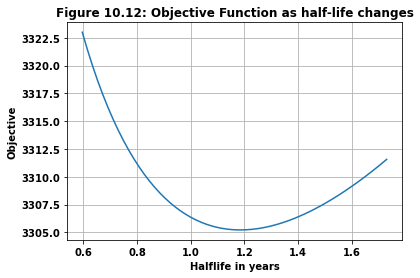

In [18]:
#Map of objective with respect to half-life

halflife=int(halflife)
delta_halflife=int(halflife/2)

x=np.arange(halflife-delta_halflife,halflife+delta_halflife)
y=[IntegratedCorrObj(np.log((.5)**(-1/h)-1)) for h in x]

plt.plot(x/periodicity,y)
plt.title("Figure 10.12: Objective Function as half-life changes")
plt.xlabel("Halflife in years")
plt.ylabel("Objective")
plt.grid()
plt.show();

This makes it hard to trust the $\lambda$ value resulting from this process.

Let's try the mean-reverting model \eqref{eq:mean_reverting}. It has two parameters, $\alpha$ and $\beta$, along with the anchor matrix $\Omega$. Perhaps this formula will lead to a better objective function.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Optimal alpha, beta: 0.014473612560970664 0.9766134450628321
Optimal objective function: 3279.846605143996
Half-life (years): 0.5632839147429579


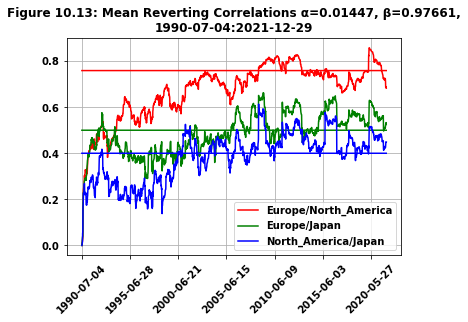

In [19]:
def MeanRevCorrObj(params):
    #Compute time series of quasi-correlation
    #matrices from InData using mean reverting
    #formula 10.45. Standardize them and apply
    #formula 10.49. Returns scalar 10.49
    
    #Extract parameters
    alpha,beta=params
    #Enforce bounds
    if alpha<0 or beta<0:
        return(10**20)
    elif (alpha+beta)>.999:
        return(10**20)
    obj10p49=0
    #Initial omega is obtained through correlation targeting
    Rlong=np.corrcoef(InData.T)
    previousq=np.identity(len(InData[0]))
    #Form new shock matrix
    for i in range(len(InData)):
        #standardize previous q matrix
        #and compute contribution to objective
        #function
        stdmtrx=np.diag([1/np.sqrt(previousq[s,s]) \
                         for s in range(len(previousq))])
        previousr=np.matmul(stdmtrx,np.matmul(previousq,stdmtrx))
        #objective function
        obj10p49+=np.log(np.linalg.det(previousr))
        shockvec=np.array(InData[i])
        vec1=np.matmul(shockvec,np.linalg.inv(previousr))
        #This makes obj10p49 into a 1,1 matrix
        obj10p49+=np.matmul(vec1,shockvec)
              
        #Update q matrix
        shockvec=np.mat(shockvec)
        shockmat=np.matmul(shockvec.T,shockvec)
        previousq=(1-alpha-beta)*Rlong+alpha*shockmat+beta*previousq
    return(obj10p49[0,0])
#Done with MeanRevCorrObj

import scipy.optimize as scpo
#alpha and beta positive
corr_bounds = scpo.Bounds([0,0],[np.inf,np.inf])
#Sum of alpha and beta is less than 1
corr_linear_constraint = \
    scpo.LinearConstraint([[1, 1]],[0],[.999])

initparams=[.02,.93]

results = scpo.minimize(MeanRevCorrObj, \
        initparams, \
        method='trust-constr', \
        jac='2-point', \
        hess=scpo.SR1(), \
        bounds=corr_bounds, \
        constraints=corr_linear_constraint)

alpha,beta=results.x
print('Optimal alpha, beta:',alpha,beta)
print('Optimal objective function:',results.fun)
halflife=-np.log(2)/np.log(beta)
print('Half-life (years):',halflife/periodicity)

#Compute mean reverting correlations
nobs=len(InData)
nsecs=len(InData[0])
previousq=np.identity(nsecs)
Rlong=np.corrcoef(InData.T)
rmatrices=[]
for i in range(nobs):
    stdmtrx=np.diag([1/np.sqrt(previousq[s,s]) for s in range(nsecs)])
    rmatrices.append(np.matmul(stdmtrx,np.matmul(previousq,stdmtrx)))
    shockvec=np.mat(np.array(InData[i]))
    #Update q matrix
    shockmat=np.matmul(shockvec.T,shockvec)
    previousq=(1-alpha-beta)*Rlong+alpha*shockmat+beta*previousq

#Plot mean-reverting correlations
iccol=['r','g','b']
xtitle='Figure 10.13: Mean Reverting Correlations α=%1.5f' % alpha
xtitle+=', β=%1.5f' % beta
xtitle+=',\n'+min(df_logs.index.strftime("%Y-%m-%d"))+':'+ \
             max(df_logs.index.strftime("%Y-%m-%d"))
dates=df_logs.index
stride=5*periodicity
plot_corrs(dates,rmatrices,corr_matrix,iccol,stride,xtitle)

The improvement in the objective function from the integrated model is marginal. The optimal $\alpha$ and $\beta$ sum to less than one so the correlation matrices retain positive definiteness as they evolve.

The half-life for the mean-reverting model is determined by $\beta$ since iterating \eqref{eq:mean_reverting} backward gives increasing powers of $\beta$ next to the shocks $\epsilon\epsilon^{\intercal}$. Even though the solution $\beta$ is not far from the $1-\lambda$ from the integrated method, the half-life is noticeably smaller than the one resulting from the integrated model. This is consistent with the shape of Figure 10.12.

### 10.8.3 MacGyver Method ###

The sad fact of estimating parameters by maximum likelihood methods is that the assumptions behind maximum likelihood are likely to be violated. The idea is to find the parameters that produce a pattern that is most likely to match the empirical data, but the assumptions about the underlying distribution necessary to compute the likelihood are often unrealistic.

There are a variety of quasi-maximum-likelihood methods that may not be as statistically pure as maximum likelihood but that seem to make sense.
Robert Engle suggests the **`MacGyver method`** to estimate parameters in correlation modeling. This is named after a [television series](https://www.cbs.com/shows/macgyver/) where the protagonist MacGyver used clever scientific tricks to solve problems. The MacGyver (really Engle) method is to estimate the parameters ($\lambda$ for the integrated model, $\alpha$ and $\beta$ for the mean-reverting model, etc.) for each pair of assets separately. 

This is exactly what we said not to do at the beginning of Section 10.8! However, the MacGyver method doesn't stop at the individual parameters: it combines them by taking the mean or the median, thus producing the necessary parameter restriction. This method also gives an idea of a confidence interval around the parameter by looking at the range of individual parameters.

Since the MacGyver method calls for looking at one quasi-correlation at a time, the integrated method would become a series of scalar equations:
$$q_{i,j,t}=\lambda_{i,j}\epsilon_{i,t-1}\epsilon_{j,t-1}+(1-\lambda_{i,j}q_{i,j,t-1}\label{eq:macgyver_integ}\tag{10.50}$$

The (opposite of) the log-likelihood function, i.e. what we want to minimize, is:
$$LML_{q_{i,j,t}}=\sum_{t=1}^T{\bigl[ln(1-q_{i,j,t}^2)+\frac{\epsilon_{i,t}^2+\epsilon_{j,t}^2-2q_{i,j,t}\epsilon_{i,t}\epsilon_{j,t}}{1-q_{i,j,t}^2}\bigr]}\label{eq:macgyver_lml}\tag{10.51}$$
A trick similar to pseudo-delta functions (Figure 8.10) can be used to force parameters ($\lambda$ in the integrated model, $\alpha$ and $\beta$ in the mean-reverting model) to lie in the interval $(0,1)$. Set the parameter equal to an expression of the form $\frac{exp(s)}{1+exp(s)}$, where $s$ is an unconstrained real number. Then solve for $s$ instead of the original parameter.

The code segment below tries the MacGyver technique for the three correlation pairs in our regional stock index example.

In [20]:
#MacGyver method - pairwise integrated
minimal=10**(-20)
xlams=[]
for it in range(len(tickerlist)-1):
    tick1=tickerlist[it]
    for jt in range(it+1,len(tickerlist)):
        tick2=tickerlist[jt]
        InData=np.array(dfeps[[tick1,tick2]])
        result=minimize_scalar(IntegratedCorrObj)
        xlamopt=np.exp(result.x)/(1+np.exp(result.x))
        print(tick1,tick2)
        print('    Optimal lambda:',xlamopt)
        print('    Optimal objective function:', \
              result.fun)
        if np.absolute(xlamopt)<minimal or xlamopt>=1:
            halflife=0
        else:
            halflife=-np.log(2)/np.log(1-xlamopt)
        print('    Half-life (years):',halflife/periodicity)
        xlams.append(xlamopt)

print('\nMedian MacGyver lambda:',np.median(xlams))

Europe North_America
    Optimal lambda: 0.030286039199903934
    Optimal objective function: 2118.933741568306
    Half-life (years): 0.43342960925094237
Europe Japan
    Optimal lambda: 0.009509218717723778
    Optimal objective function: 2818.8779337054375
    Half-life (years): 1.3950961871326746
North_America Japan
    Optimal lambda: 0.006421768799189656
    Optimal objective function: 2986.3935339666
    Half-life (years): 2.0690416665085523

Median MacGyver lambda: 0.009509218717723778


The median MacGyver $\lambda$ is not too far from the $\lambda$ we got from the integrated method as shown in Figure 10.11. The range of half-lives doesn't give us much confidence in the central value.

In addition to giving an idea of the confidence interval around the parameter, the MacGyver method is useful for incomplete data. For example, when we brought the Euro into our currency data to form Figure 5.1, we needed to restrict the time period to start in 1999. The Swissie, pound sterling, and the yen have data going back decades before that, but the Euro didn't start trading until the beginning of 1999. Before that, each Eurozone country had its own currency. The MacGyver method would allow us to use the extra decades of data for parameter estimation between pairs that existed before the Euro, while restricting the time period for pairs that include the Euro.

However, if after examining parameter ranges we find that we don't have confidence in one of the DCC models, we can simply take rolling historical or EWMA correlations as a low-tech way of predicting future correlations.

## Chapter 10 Footnotes
<a name="ten_footnotes"></a>
<br>
$^1$ [Anticipating Correlations](https://www.jstor.org/stable/j.ctt7sb6w) is the title of a book by Robert Engle, stressing the importance of this kind of forecasting activity. The implementations reported in Section 10.8 are based on this book.
<br><br>

$^2$ CBOE actually uses a sampling technique; only the $3$-month implied volatilities of the $50$ largest components of the $500$-security index are taken into account. https://go.cboe.com/l/77532/2021-10-14/bwm39g.
<br><br>

$^3$ Sklar's Theorem is due to Abe Sklar in 1959. This version is from Gal Eidan, *Copulas in Machine Learning*, in Jaworski et. al., Copulae in Mathematical and Quantitative Finance, Springer 2012, p. 41.
<br><br>

$^4$ There are many collateralized products with initials "CxO," where in addition to x=D for debt, we can have x=L for loan; x=M for mortgage; and other kinds of **`structured finance`** arrangements. There are even CxOs consisting of CxOs, called CxO-squareds. We will use CDO as a generic term for these kinds of structures.
<br><br>

$^5$ John Maynard Keynes, A Tract on Monetary Reform, MacMillan and Co., 1924, p. 80. https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnx0YWxsZXJ0ZW9yaWFtb25ldGFyaWF1YmF8Z3g6NjM5MWU1YTkxNjhiM2JmNw
<br><br>

$^6$ The financial analyst A. Gary Shilling seems to be the actual source of this saying, although it's often attributed to Keynes. https://quoteinvestigator.com/2011/08/09/remain-solvent/